In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np



In [ ]:
# Hyperparamètres
latent_dim = 100  # Dimension du bruit aléatoire
num_classes = 10  # Nombre de classes dans MNIST (0-9)
img_size = 28  # Taille des images
channels = 1  # Canal (1 pour grayscale)
batch_size = 64
lr = 0.0002  # Taux d'apprentissage
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Dataset MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalisation entre -1 et 1
])
mnist = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
dataloader = DataLoader(mnist, batch_size=batch_size, shuffle=True)


Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 476kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.85MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.09MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
import torch
import torch.nn as nn

# Générateur : génère des images à partir d'un vecteur aléatoire (latent) et d'une classe donnée.
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_size, channels):
        super(Generator, self).__init__()

        # Embedding des labels (vecteur dense associé à chaque classe)
        self.label_emb = nn.Embedding(num_classes, num_classes)  # Taille num_classes pour un one-hot-like embedding

        # Taille initiale après le premier reshape (réduction de la taille spatiale)
        self.init_size = img_size // 4

        # Couche entièrement connectée pour projeter l'entrée (bruit + labels) en un tenseur spatial.
        self.l1 = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128 * self.init_size ** 2)  # Projection dans un espace de caractéristiques initiales
        )

        # Blocs de convolutions pour augmenter la taille spatiale et affiner l'image
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),  # Normalisation des canaux pour stabiliser l'apprentissage
            nn.Upsample(scale_factor=2),  # Agrandissement de la taille spatiale (doublement)
            nn.Conv2d(128, 128, 3, stride=1, padding=1),  # Convolution pour affiner les motifs
            nn.BatchNorm2d(128, 0.8),  # Nouvelle normalisation des canaux
            nn.LeakyReLU(0.2, inplace=True),  # Activation non-linéaire pour ajouter de la complexité
            nn.Upsample(scale_factor=2),  # Deuxième agrandissement spatial
            nn.Conv2d(128, channels, 3, stride=1, padding=1),  # Convolution finale pour générer l'image finale
            nn.Tanh()  # Activation Tanh pour ramener les valeurs des pixels entre -1 et 1
        )

    def forward(self, noise, labels):
        # Concatenation du bruit et des embeddings de labels
        gen_input = torch.cat((noise, self.label_emb(labels)), -1)

        # Projection linéaire et mise en forme pour convolution
        out = self.l1(gen_input)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)  # Reshape pour correspondre à une entrée convolutive

        # Passage dans les blocs convolutifs pour générer l'image
        img = self.conv_blocks(out)
        return img


# Discriminateur : classe le contenu généré comme réel ou faux (GAN classique)
class Discriminator(nn.Module):
    def __init__(self, num_classes, img_size, channels):
        super(Discriminator, self).__init__()

        # Embedding des labels pour les concaténer à l'image
        self.label_emb = nn.Embedding(num_classes, num_classes)

        # Modèle séquentiel pour classifier l'entrée image
        self.model = nn.Sequential(
            nn.Linear(num_classes + int(channels * img_size ** 2), 512),  # Combinaison image + label dans un espace latent
            nn.LeakyReLU(0.2, inplace=True),  # Activation pour capturer des motifs complexes
            nn.Linear(512, 512),  # Projection dans un espace réduit
            nn.Dropout(0.4),  # Régularisation pour éviter le surapprentissage
            nn.LeakyReLU(0.2, inplace=True),  # Activation supplémentaire
            nn.Linear(512, 1),  # Sortie unique pour la validité
            nn.Sigmoid()  # Probabilité de validité (entre 0 et 1)
        )

    def forward(self, img, labels):
        # Mise à plat de l'image et concaténation avec les embeddings des labels
        d_in = torch.cat((img.view(img.size(0), -1), self.label_emb(labels)), -1)

        # Passage dans le discriminateur
        validity = self.model(d_in)
        return validity


In [ ]:
# Initialisation des modèles
generator = Generator(latent_dim, num_classes, img_size, channels).to(device)
discriminator = Discriminator(num_classes, img_size, channels).to(device)

# Optimiseurs
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Fonction de perte
adversarial_loss = nn.BCELoss()


In [ ]:
for epoch in range(50):
    for i, (imgs, labels) in enumerate(dataloader):
        batch_size = imgs.size(0)

        # Réalités et faux labels
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        # Préparer les données
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        # 1. Entraîner le Générateur
        optimizer_G.zero_grad()

        # Bruit aléatoire et étiquettes aléatoires
        z = torch.randn(batch_size, latent_dim, device=device)
        gen_labels = torch.randint(0, num_classes, (batch_size,), device=device)

        # Générer des images
        gen_imgs = generator(z, gen_labels)

        # Calculer la perte du générateur
        g_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), valid)

        # Backpropagation
        g_loss.backward()
        optimizer_G.step()

        # 2. Entraîner le Discriminateur
        optimizer_D.zero_grad()

        # Perte pour les vraies images
        real_loss = adversarial_loss(discriminator(real_imgs, labels), valid)

        # Perte pour les fausses images
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_labels), fake)

        # Perte totale du Discriminateur
        d_loss = (real_loss + fake_loss) / 2

        # Backpropagation
        d_loss.backward()
        optimizer_D.step()

        # Affichage des logs
        if i % 100 == 0:
            print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")


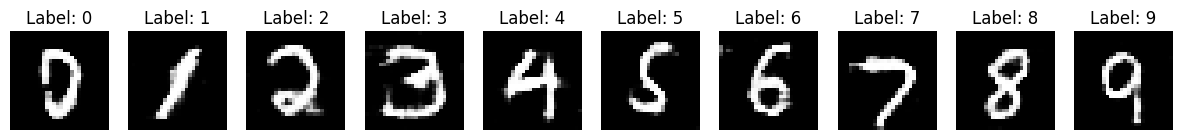

In [ ]:
import matplotlib.pyplot as plt

def generate_and_save_images(generator, num_images=10):
    z = torch.randn(num_images, latent_dim, device=device)
    labels = torch.arange(num_images, device=device)
    gen_imgs = generator(z, labels).detach().cpu()
    fig, axs = plt.subplots(1, num_images, figsize=(15, 15))
    for i, img in enumerate(gen_imgs):
        axs[i].imshow(img.squeeze(), cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(f"Label: {labels[i].item()}")
    plt.show()

# Générer des exemples
generate_and_save_images(generator)
